## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import pyodbc       
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
rcParams['figure.figsize'] = 10,6

## Loading the Dataset

In [2]:
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                      "Server=DESKTOP-A6QRAK4;"
                       "Database=AdventureWorks2012;"
                      "Trusted_Connection=yes;")

dataset = pd.read_sql_query(
    '''SELECT 
B.[OrderDate]  
,B.[OrderDate] AS Quarter
,A.[LineTotal] AS Sales_Revenue
,F.[Name] AS Territory
,CASE WHEN B.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'In Store' END AS Sales_Channel
FROM  [Sales].[SalesOrderDetail] AS A
LEFT JOIN [Sales].[SalesOrderHeader] AS B
ON A.[SalesOrderID] = B.[SalesOrderID] 
LEFT JOIN [Sales].[SalesTerritory] AS F
ON B.[TerritoryID] = F.[TerritoryID]''', cnxn)

print(dataset)

        OrderDate    Quarter  Sales_Revenue  Territory Sales_Channel
0      2011-05-31 2011-05-31       2024.994  Southeast      In Store
1      2011-05-31 2011-05-31       6074.982  Southeast      In Store
2      2011-05-31 2011-05-31       2024.994  Southeast      In Store
3      2011-05-31 2011-05-31       2039.994  Southeast      In Store
4      2011-05-31 2011-05-31       2039.994  Southeast      In Store
...           ...        ...            ...        ...           ...
121312 2014-06-30 2014-06-30         21.980     Canada        Online
121313 2014-06-30 2014-06-30          8.990     Canada        Online
121314 2014-06-30 2014-06-30         21.980     Canada        Online
121315 2014-06-30 2014-06-30        159.000     Canada        Online
121316 2014-06-30 2014-06-30          8.990     Canada        Online

[121317 rows x 5 columns]


In [3]:
## Parse strings to Datetime Type
dataset['Quarter'] = (dataset['Quarter'].dt.quarter)
dataset['OrderDate'] = pd.to_datetime(dataset['OrderDate'].dt.strftime("%Y-%m"), infer_datetime_format=True)
indexedDataset = dataset.set_index(['OrderDate'])

In [4]:
indexedDataset

,Quarter,Sales_Revenue,Territory,Sales_Channel
OrderDate,,,,
2011-05-01,2,2024.994,Southeast,In Store
2011-05-01,2,6074.982,Southeast,In Store
2011-05-01,2,2024.994,Southeast,In Store
2011-05-01,2,2039.994,Southeast,In Store
2011-05-01,2,2039.994,Southeast,In Store
...,...,...,...,...
2014-06-01,2,21.980,Canada,Online
2014-06-01,2,8.990,Canada,Online
2014-06-01,2,21.980,Canada,Online


In [5]:
indexedDataset['Sales_Channel'].value_counts()

In Store    60919
Online      60398
Name: Sales_Channel, dtype: int64

In [6]:
## Separating transactions for Territories & Channel
indexedDataset1=(indexedDataset[indexedDataset['Territory']=="Canada"]
         .groupby(['OrderDate','Territory'])['Sales_Revenue']
         .sum().unstack().reset_index().fillna(0)
         .set_index('OrderDate'))
indexedDataset1.head()  ## Viewing transaction basket

Territory,Canada
OrderDate,
2011-05-01,118939.166000
2011-06-01,18387.168200
2011-07-01,345899.772164
2011-08-01,458439.476020
2011-09-01,11929.726400


## Data  Preparation

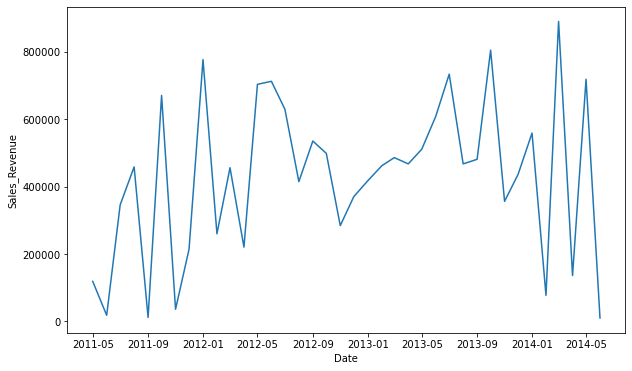

In [7]:
## Plot Graph

plt.xlabel("Date")
plt.ylabel("Sales_Revenue")
plt.plot(indexedDataset1)

In [8]:
## Determining rolling statistics
rolmean = indexedDataset1.rolling(window=12).mean()

rolstd = indexedDataset1.rolling(window=12).std()
print(rolmean, rolstd)

Territory          Canada
OrderDate                
2011-05-01            NaN
2011-06-01            NaN
2011-07-01            NaN
2011-08-01            NaN
2011-09-01            NaN
2011-10-01            NaN
2011-11-01            NaN
2011-12-01            NaN
2012-01-01            NaN
2012-02-01            NaN
2012-03-01            NaN
2012-04-01  298973.797330
2012-05-01  347673.651599
2012-06-01  405496.624951
2012-07-01  429107.298723
2012-08-01  425469.130485
2012-09-01  469070.959163
2012-10-01  454751.834628
2012-11-01  475424.271855
2012-12-01  488421.456106
2013-01-01  458457.674401
2013-02-01  475248.248330
2013-03-01  477741.787384
2013-04-01  498309.629312
2013-05-01  482264.902234
2013-06-01  473574.209218
2013-07-01  482259.666931
2013-08-01  486637.798533
2013-09-01  482119.830863
2013-10-01  507630.594279
2013-11-01  513624.032320
2013-12-01  519126.463616
2014-01-01  530925.756472
2014-02-01  498920.880586
2014-03-01  532571.077057
2014-04-01  504973.160364
2014-05-01  

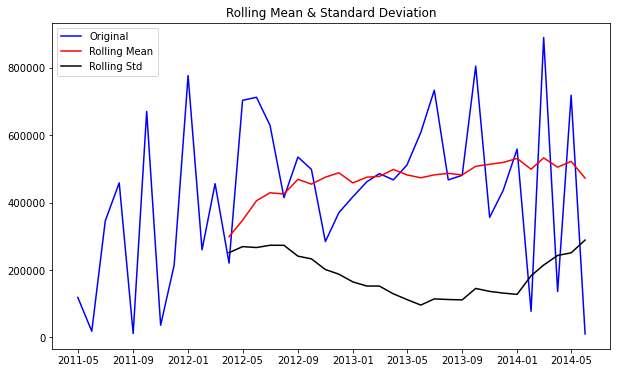

In [9]:
## Plot rolling Statistics
orig = plt.plot(indexedDataset1, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show(block=False)

In [10]:
## Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset1['Canada'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.182193
p-value                         0.000706
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


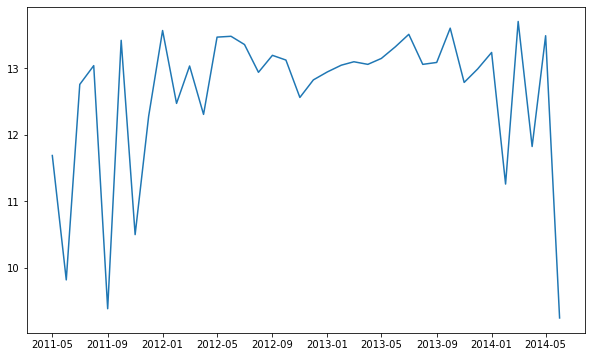

In [11]:
## Estimating the Trend
indexedDataset1_logScale = np.log(indexedDataset1)
plt.plot(indexedDataset1_logScale)
plt.show()

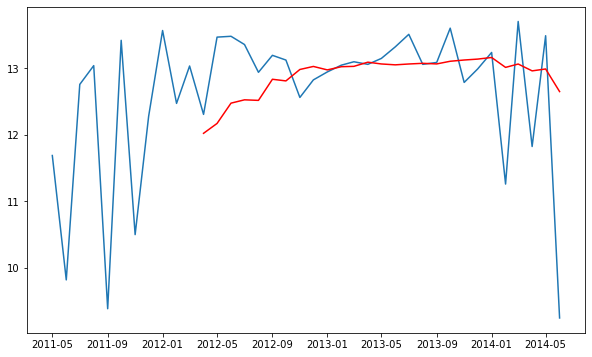

In [12]:
## Getting the Moving Average
movingAverage = indexedDataset1_logScale.rolling(window=12).mean()
movingSTD = indexedDataset1_logScale.rolling(window=12).std()
plt.plot(indexedDataset1_logScale)
plt.plot(movingAverage, color='red') ## Trend is still not Stationery
plt.show()

In [13]:
## Get the difference between the moving average and the actual Sales Revenue

datasetLogScaleMinusMovingAverage = indexedDataset1_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

## Remove nan values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head

<bound method NDFrame.head of Territory     Canada
OrderDate           
2012-04-01  0.284101
2012-05-01  1.295760
2012-06-01  1.003638
2012-07-01  0.829822
2012-08-01  0.421420
2012-09-01  0.359259
2012-10-01  0.312965
2012-11-01 -0.419993
2012-12-01 -0.201846
2013-01-01 -0.030589
2013-02-01  0.022823
2013-03-01  0.068983
2013-04-01 -0.032574
2013-05-01  0.082974
2013-06-01  0.270321
2013-07-01  0.445179
2013-08-01 -0.015511
2013-09-01  0.022112
2013-10-01  0.496843
2013-11-01 -0.336626
2013-12-01 -0.147915
2014-01-01  0.075297
2014-02-01 -1.751405
2014-03-01  0.638865
2014-04-01 -1.135328
2014-05-01  0.499198
2014-06-01 -3.398498>

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    ## Determining Rolling Statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    ## Plot rolling Statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    ## Perform Dickey-Fuller Test:
    print('Results of Dickey-Fuller Test:')
    timeseries = indexedDataset1.loc[:, 'Canada'].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)       

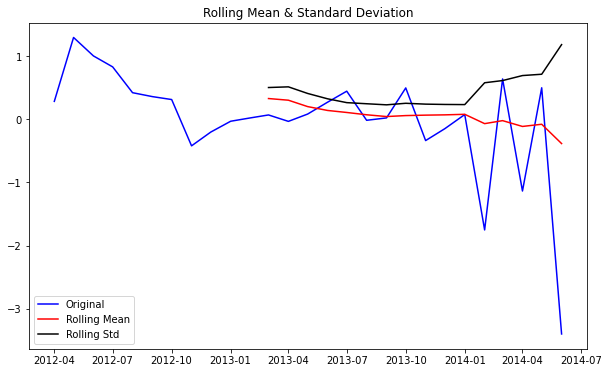

Results of Dickey-Fuller Test:
Test Statistic                 -4.182193
p-value                         0.000706
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)

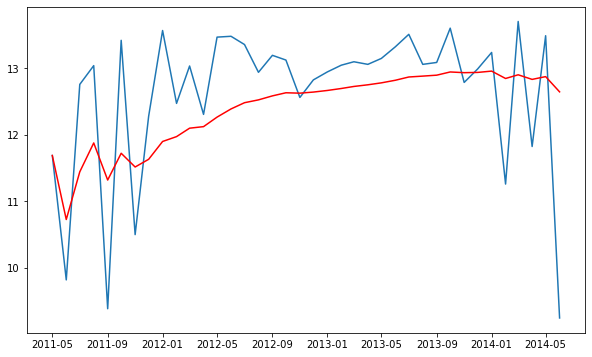

In [16]:
## To see the trend that's present inside a Time Series, you get the Weighted Average of Time Series
exponentialDecayWeightedAverage = indexedDataset1_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset1_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

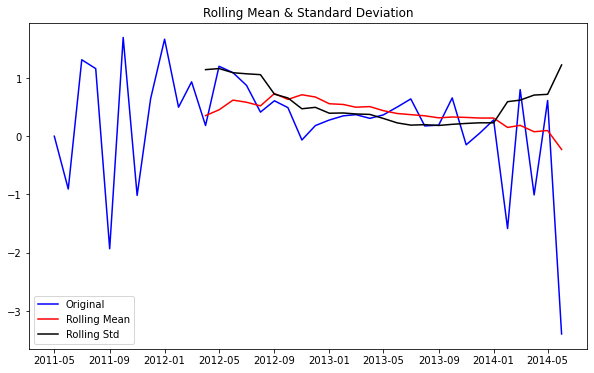

Results of Dickey-Fuller Test:
Test Statistic                 -4.182193
p-value                         0.000706
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [17]:
## Subtract Simple Mean from Log Scale and check again for Stationarity
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset1_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

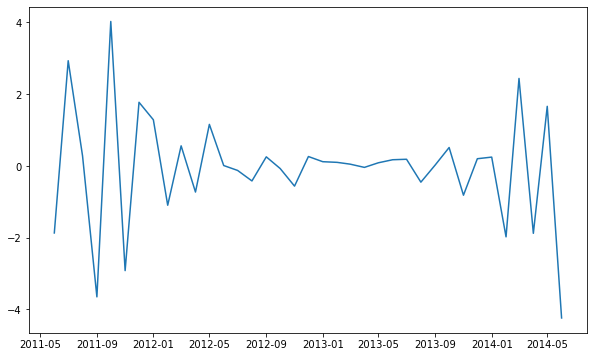

In [18]:
datasetLogDiffShifting = indexedDataset1_logScale - indexedDataset1_logScale.shift()
plt.plot(datasetLogDiffShifting)

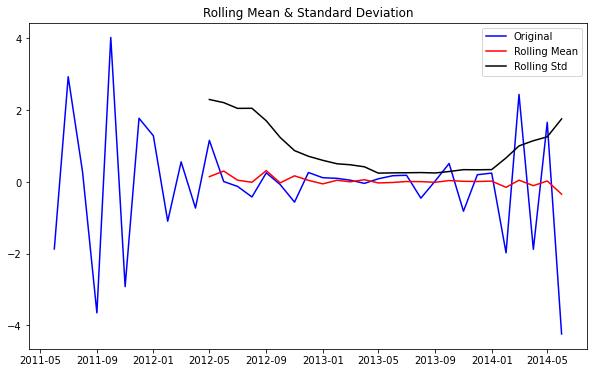

Results of Dickey-Fuller Test:
Test Statistic                 -4.182193
p-value                         0.000706
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [19]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

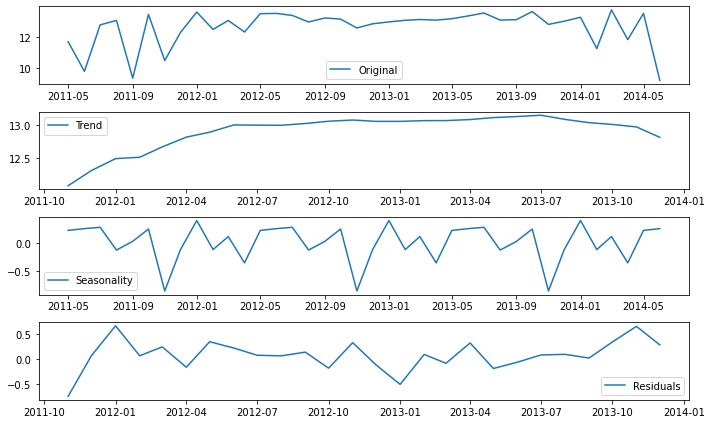

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset1_logScale)      
    
trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset1_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

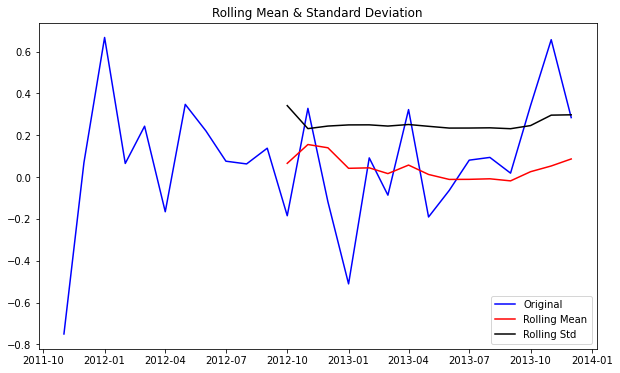

Results of Dickey-Fuller Test:
Test Statistic                 -4.182193
p-value                         0.000706
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [21]:
#There can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## Making Predictions

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


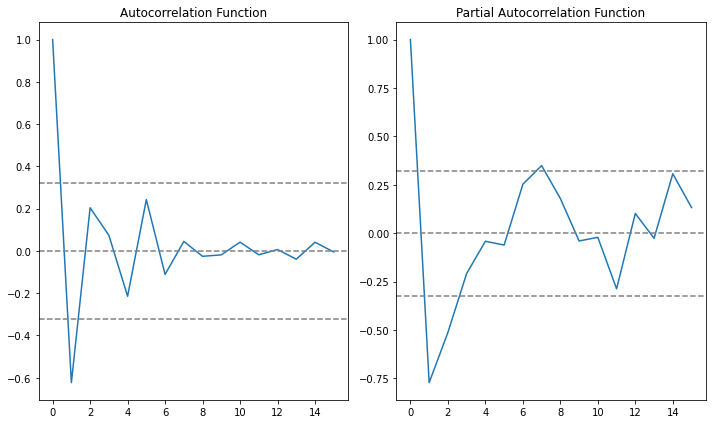

In [22]:
#Plotting ACF & PACF 

from statsmodels.tsa.stattools import acf, pacf
  
lag_acf = acf(datasetLogDiffShifting, nlags=15)
lag_pacf = pacf(datasetLogDiffShifting, nlags=15, method='ols')


#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout() 

In [23]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



C:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.war

Plotting AR model


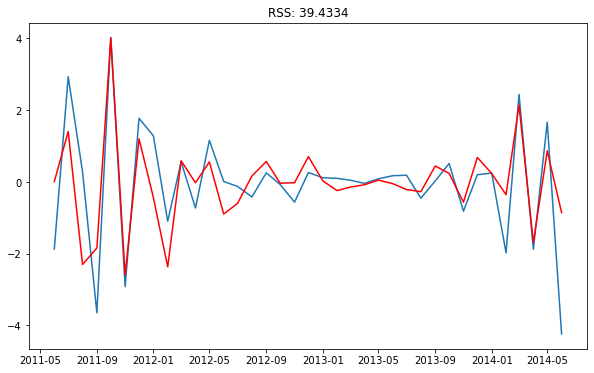

In [24]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset1_logScale, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting["Canada"])**2))
print('Plotting AR model')

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 

Plotting MA model


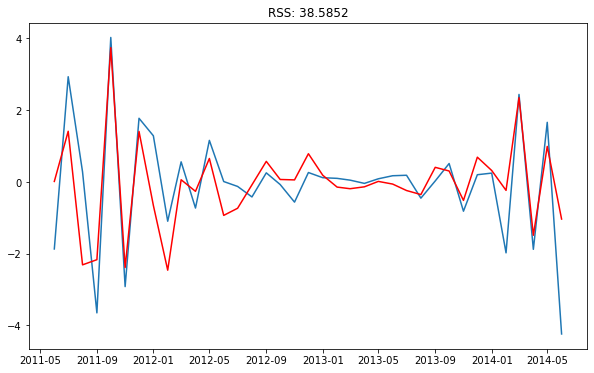

In [25]:
#MA MODEL
model = ARIMA(indexedDataset1_logScale, order=(2, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting["Canada"])**2))
print('Plotting MA model')

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 

Plotting ARIMA model


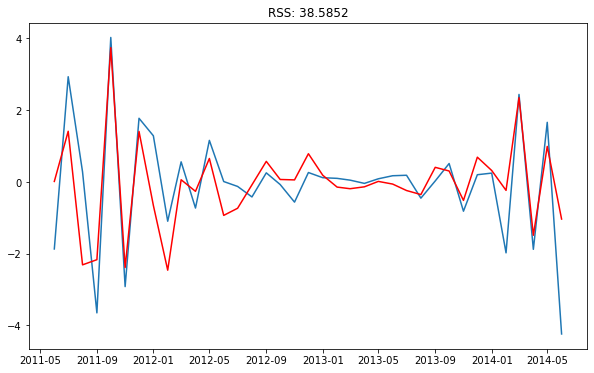

In [26]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset1_logScale, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Canada'])**2))
print('Plotting ARIMA model')

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

OrderDate
2011-06-01    0.015185
2011-07-01    1.414045
2011-08-01   -2.309696
2011-09-01   -2.165781
2011-10-01    3.744059
dtype: float64


In [28]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

OrderDate
2011-06-01    0.015185
2011-07-01    1.429230
2011-08-01   -0.880466
2011-09-01   -3.046247
2011-10-01    0.697812
dtype: float64


In [29]:
#predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

predictions_ARIMA_log = pd.Series(indexedDataset1_logScale['Canada'].iloc[0], index=indexedDataset1_logScale['Canada'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

OrderDate
2011-05-01    11.686367
2011-06-01    11.701552
2011-07-01    13.115598
2011-08-01    10.805902
2011-09-01     8.640120
dtype: float64

Text(0.5, 1.0, 'RMSE: 470660.1661')

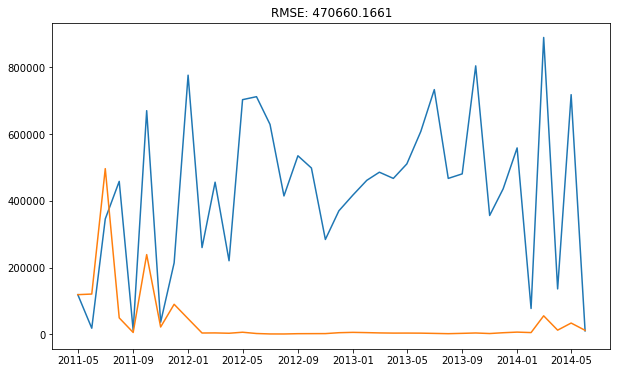

In [30]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset1)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset1["Canada"])**2)/len(indexedDataset1["Canada"])))

In [34]:
indexedDataset1_logScale.head() # Viewing the count of dataset

Territory,Canada
OrderDate,
2011-05-01,11.686367
2011-06-01,9.819408
2011-07-01,12.753904
2011-08-01,13.035584
2011-09-01,9.386789


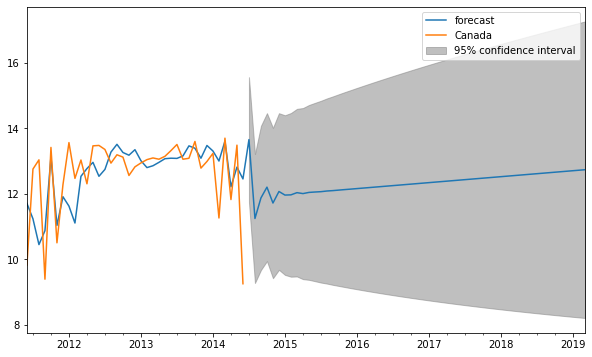

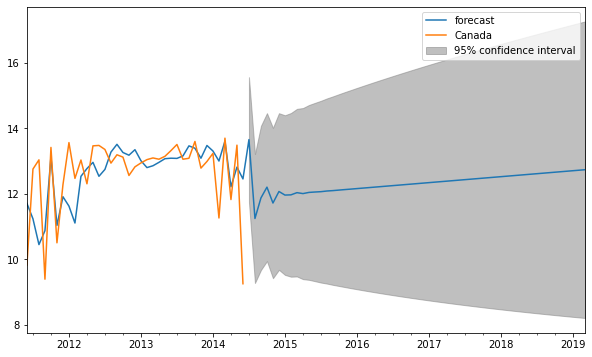

In [32]:
results_ARIMA.plot_predict(1, 94) # Prediction in graphical format

In [33]:
results_ARIMA.forecast(steps=60)# Prediction in Data format

(array([13.65417894, 11.24259472, 11.87154812, 12.20047511, 11.71532625,
        12.06785399, 11.95849498, 11.96527801, 12.03238272, 12.00395487,
        12.03979   , 12.05197821, 12.06249545, 12.08293852, 12.09506686,
        12.11112233, 12.12661522, 12.14121381, 12.15681565, 12.17183556,
        12.18702037, 12.20226451, 12.21739664, 12.23260817, 12.24778833,
        12.26296836, 12.27815969, 12.29334093, 12.30852719, 12.32371254,
        12.33889692, 12.3540825 , 12.36926734, 12.38445242, 12.39963755,
        12.41482255, 12.43000765, 12.4451927 , 12.46037776, 12.47556283,
        12.49074789, 12.50593296, 12.52111802, 12.53630308, 12.55148815,
        12.56667321, 12.58185827, 12.59704334, 12.6122284 , 12.62741346,
        12.64259853, 12.65778359, 12.67296865, 12.68815372, 12.70333878,
        12.71852385, 12.73370891, 12.74889397, 12.76407904, 12.7792641 ]),
 array([0.97398196, 1.00641048, 1.12436558, 1.15429758, 1.17285717,
        1.22150185, 1.24494988, 1.27680207, 1.30731355